In [4]:
import os, sys
import warnings
from google.colab import drive
drive.mount('/content/drive')

my_path = '/content/notebooks'
# Colab Notebooks 안에 my_env 폴더에 패키지 저장
os.symlink('/content/drive/My Drive/Colab Notebooks/my_env', my_path)
sys.path.insert(0, my_path)


warnings.filterwarnings("ignore")  # avoid printing out absolute paths

Mounted at /content/drive


In [8]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [52]:
import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [ ]:
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning
import pytorch_lightning as pl
print(pl.__version__)

In [ ]:
!pip install pytorch-forecasting

## Load Data

In [9]:
from pytorch_forecasting.data.examples import get_stallion_data

data = get_stallion_data()


In [48]:
data.shape

(21000, 31)

In [10]:
data.head()

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,easter_day,good_friday,new_year,christmas,labor_day,independence_day,revolution_day_memorial,regional_games,fifa_u_17_world_cup,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries
0,Agency_22,SKU_01,52.2720,2013-01-01,492612703,718394219,25.845238,1168.903668,1069.166193,99.737475,48151,132110,0,0,1,0,0,0,0,0,0,0,0,0,8.532566,0
238,Agency_37,SKU_04,0.0000,2013-01-01,492612703,718394219,26.505000,1852.273642,1611.466298,240.807344,32769,96761,0,0,1,0,0,0,0,0,0,0,0,0,13.000635,5
237,Agency_59,SKU_03,812.9214,2013-01-01,492612703,718394219,22.219737,1270.795012,1197.184260,73.610752,1219986,218902,0,0,1,0,0,0,0,0,0,0,0,0,5.792496,9
236,Agency_11,SKU_01,316.4400,2013-01-01,492612703,718394219,25.360000,1176.155397,1082.757488,93.397909,135561,100461,0,0,1,0,0,0,0,0,0,0,0,0,7.940950,14
235,Agency_05,SKU_05,420.9093,2013-01-01,492612703,718394219,24.079012,1327.003396,1207.822992,119.180404,3044268,182944,0,0,1,0,0,0,0,0,0,0,0,0,8.981168,22


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21000 entries, 0 to 6650
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   agency                            21000 non-null  category      
 1   sku                               21000 non-null  category      
 2   volume                            21000 non-null  float64       
 3   date                              21000 non-null  datetime64[ns]
 4   industry_volume                   21000 non-null  int64         
 5   soda_volume                       21000 non-null  int64         
 6   avg_max_temp                      21000 non-null  float64       
 7   price_regular                     21000 non-null  float64       
 8   price_actual                      21000 non-null  float64       
 9   discount                          21000 non-null  float64       
 10  avg_population_2017               21000 non-nul

## Structure of Data
agency+sku 가 2013-01-01~2017-12-01 달마다 측정된 데이터

In [18]:
data[data["agency"]=="Agency_22"]

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,easter_day,good_friday,new_year,christmas,labor_day,independence_day,revolution_day_memorial,regional_games,fifa_u_17_world_cup,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx
0,Agency_22,SKU_01,52.2720,2013-01-01,492612703,718394219,25.845238,1168.903668,1069.166193,99.737475,48151,132110,0,0,1,0,0,0,0,0,0,0,0,0,8.532566,0,0
17,Agency_22,SKU_04,31.0554,2013-01-01,492612703,718394219,25.845238,1742.112676,1598.414189,143.698487,48151,132110,0,0,1,0,0,0,0,0,0,0,0,0,8.248519,1,0
4,Agency_22,SKU_05,238.5387,2013-01-01,492612703,718394219,25.845238,1310.176057,1203.875711,106.300346,48151,132110,0,0,1,0,0,0,0,0,0,0,0,0,8.113440,3,0
1,Agency_22,SKU_02,110.7000,2013-01-01,492612703,718394219,25.845238,1167.000000,1067.257500,99.742500,48151,132110,0,0,1,0,0,0,0,0,0,0,0,0,8.546915,4,0
36,Agency_22,SKU_03,86.4612,2013-01-01,492612703,718394219,25.845238,1258.729104,1156.645866,102.083238,48151,132110,0,0,1,0,0,0,0,0,0,0,0,0,8.110024,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6787,Agency_22,SKU_03,79.7778,2017-12-01,618073219,919709619,26.915610,1676.542327,1437.756989,238.785338,48151,132110,0,0,0,1,0,0,0,0,0,0,0,0,14.242726,2,59
6757,Agency_22,SKU_01,120.2040,2017-12-01,618073219,919709619,26.915610,1712.552954,1389.759996,322.792958,48151,132110,0,0,0,1,0,0,0,0,0,0,0,0,18.848641,0,59
6759,Agency_22,SKU_02,165.9960,2017-12-01,618073219,919709619,26.915610,1716.682173,1394.875814,321.806359,48151,132110,0,0,0,1,0,0,0,0,0,0,0,0,18.745832,4,59
6761,Agency_22,SKU_05,368.9586,2017-12-01,618073219,919709619,26.915610,1901.999151,1545.220964,356.778187,48151,132110,0,0,0,1,0,0,0,0,0,0,0,0,18.758062,3,59


In [21]:
data[(data["agency"]=="Agency_22") & (data["sku"]=="SKU_01")]

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,easter_day,good_friday,new_year,christmas,labor_day,independence_day,revolution_day_memorial,regional_games,fifa_u_17_world_cup,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx
0,Agency_22,SKU_01,52.272,2013-01-01,492612703,718394219,25.845238,1168.903668,1069.166193,99.737475,48151,132110,0,0,1,0,0,0,0,0,0,0,0,0,8.532566,0,0
7096,Agency_22,SKU_01,62.532,2013-02-01,431937346,753938444,29.313095,1169.357513,1069.465566,99.891947,48151,132110,0,0,0,0,0,0,0,0,0,0,0,0,8.542464,0,1
8898,Agency_22,SKU_01,74.196,2013-03-01,509281531,892192092,29.422353,1204.673581,1102.337519,102.336062,48151,132110,1,1,0,0,0,0,0,0,0,0,0,1,8.494920,0,2
10733,Agency_22,SKU_01,89.424,2013-04-01,532390389,838099501,32.433721,1235.187500,1129.538874,105.648626,48151,132110,0,0,0,0,0,0,0,0,0,0,0,0,8.553246,0,3
12472,Agency_22,SKU_01,79.164,2013-05-01,551755254,864420003,32.157647,1247.061989,1140.811136,106.250853,48151,132110,0,0,0,0,1,0,0,0,0,0,0,0,8.520094,0,4
14228,Agency_22,SKU_01,70.416,2013-06-01,531683569,889520921,30.989412,1252.187500,1146.437979,105.749521,48151,132110,0,0,0,0,0,0,0,0,0,0,0,0,8.445183,0,5
15929,Agency_22,SKU_01,75.276,2013-07-01,508376577,869768947,30.583529,1252.187500,1140.552636,111.634864,48151,132110,0,0,0,0,0,0,0,0,0,0,0,0,8.915188,0,6
17678,Agency_22,SKU_01,76.788,2013-08-01,532480057,757916529,30.311905,1252.187500,1138.016350,114.171150,48151,132110,0,0,0,0,0,0,0,0,0,0,0,0,9.117736,0,7
19533,Agency_22,SKU_01,56.916,2013-09-01,454252482,789624076,28.757143,1252.187500,1138.325664,113.861836,48151,132110,0,0,0,0,0,1,0,0,0,0,0,0,9.093034,0,8
1983,Agency_22,SKU_01,75.168,2013-10-01,480693900,791658684,29.263095,1252.187500,1136.148707,116.038793,48151,132110,0,0,0,0,0,0,0,0,0,0,1,0,9.266886,0,9


In [25]:
len(data[(data["agency"]=="Agency_22") & (data["sku"]=="SKU_01")])

60

## Feature Engineering

In [12]:

# add time index
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min()


In [22]:

# add additional features
data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")


In [23]:

# we want to encode special days as one variable and thus need to first reverse one-hot encoding
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]
data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
data.sample(10, random_state=521)

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,easter_day,good_friday,new_year,christmas,labor_day,independence_day,revolution_day_memorial,regional_games,fifa_u_17_world_cup,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
291,Agency_25,SKU_03,0.5076,2013-01-01,492612703,718394219,25.845238,1264.162234,1152.473405,111.688829,53598,95032,-,-,new_year,-,-,-,-,-,-,-,-,-,8.835008,228,0,1,-0.678062,1225.306376,99.650400
871,Agency_29,SKU_02,8.7480,2015-01-01,498567142,762225057,27.584615,1316.098485,1296.804924,19.293561,28329,93614,-,-,new_year,-,-,-,-,-,-,-,-,-,1.465966,177,24,1,2.168825,1634.434615,11.397086
19532,Agency_47,SKU_01,4.9680,2013-09-01,454252482,789624076,30.665957,1269.250000,1266.490490,2.759510,32183,128574,-,-,-,-,-,independence_day,-,-,-,-,-,-,0.217413,322,8,9,1.603017,2625.472644,48.295650
2089,Agency_53,SKU_07,21.6825,2013-10-01,480693900,791658684,29.197727,1193.842373,1128.124395,65.717978,1729177,111048,-,-,-,-,-,-,-,-,-,-,beer_capital,-,5.504745,240,9,10,3.076505,38.529107,2511.035175
9755,Agency_17,SKU_02,960.5520,2015-03-01,515468092,871204688,23.608120,1338.334248,1232.128069,106.206179,147910,123013,-,-,-,-,-,-,-,-,-,-,-,music_fest,7.935699,259,26,3,6.867508,2143.677462,396.022140
7561,Agency_05,SKU_03,1184.6535,2014-02-01,425528909,734443953,28.668254,1369.556376,1161.135214,208.421162,3044268,182944,-,-,-,-,-,-,-,-,-,-,-,-,15.218151,21,13,2,7.077206,1566.643589,1881.866367
19204,Agency_11,SKU_05,5.5593,2017-08-01,623319783,1049868815,31.915385,1922.486644,1651.307674,271.178970,135561,100461,-,-,-,-,-,-,-,-,-,-,-,-,14.105636,17,55,8,1.715472,1385.225478,109.699200
8781,Agency_48,SKU_04,4275.1605,2013-03-01,509281531,892192092,26.767857,1761.258209,1546.059670,215.198539,1739969,210213,easter_day,good_friday,-,-,-,-,-,-,-,-,-,music_fest,12.218455,151,2,3,8.360577,1757.950603,1925.272108
2540,Agency_07,SKU_21,0.0000,2015-10-01,544203593,761469815,28.987755,0.000000,0.000000,0.000000,1868030,175785,-,-,-,-,-,-,-,-,-,-,-,-,0.000000,300,33,10,-18.420681,0.000000,2418.719550
12084,Agency_21,SKU_03,46.3608,2017-04-01,589969396,940912941,32.478910,1675.922116,1413.571789,262.350327,26635,130092,easter_day,good_friday,-,-,-,-,-,-,-,-,-,-,15.654088,181,51,4,3.836454,2034.293024,109.381800


In [33]:
data[(data["agency"]=="Agency_22") & (data["sku"]=="SKU_01")].head()

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,easter_day,good_friday,new_year,christmas,labor_day,independence_day,revolution_day_memorial,regional_games,fifa_u_17_world_cup,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
0,Agency_22,SKU_01,52.272,2013-01-01,492612703,718394219,25.845238,1168.903668,1069.166193,99.737475,48151,132110,-,-,new_year,-,-,-,-,-,-,-,-,-,8.532566,0,0,1,3.956461,2613.377501,103.80546
7096,Agency_22,SKU_01,62.532,2013-02-01,431937346,753938444,29.313095,1169.357513,1069.465566,99.891947,48151,132110,-,-,-,-,-,-,-,-,-,-,-,-,8.542464,0,1,2,4.135678,2916.978087,121.04766
8898,Agency_22,SKU_01,74.196,2013-03-01,509281531,892192092,29.422353,1204.673581,1102.337519,102.336062,48151,132110,easter_day,good_friday,-,-,-,-,-,-,-,-,-,music_fest,8.494920,0,2,3,4.306710,3215.061952,153.84672
10733,Agency_22,SKU_01,89.424,2013-04-01,532390389,838099501,32.433721,1235.187500,1129.538874,105.648626,48151,132110,-,-,-,-,-,-,-,-,-,-,-,-,8.553246,0,3,4,4.493389,3515.822697,163.15866
12472,Agency_22,SKU_01,79.164,2013-05-01,551755254,864420003,32.157647,1247.061989,1140.811136,106.250853,48151,132110,-,-,-,-,labor_day,-,-,-,-,-,-,-,8.520094,0,4,5,4.371522,3688.107793,152.62596


## Create dataset and dataloaders

-  telling the dataset which features are categorical vs continuous
-   which are static vs varying in time
-  how we normalise the data
The EncoderNormalizer, that scales dynamically on each encoder sequence as you train, is preferred to avoid look-ahead bias induced by normalisation.   

We also choose to use the last six months as a validation set.

In [28]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length

In [29]:
data["time_idx"].max() - max_prediction_length #encoder에는 0~23, 1~24 .... 30~53 이고 decoder에서 6을 예측하는 형태

53

Making Training set

In [35]:
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff], # 53이하의 시점들만 뽑음
    time_idx="time_idx",
    target="volume",
    group_ids=["agency", "sku"],

    # encoder decoder 길이 설정
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,

    # static, varying, category 설정
    static_categoricals=["agency", "sku"],
    static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=["special_days", "month"],
    variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ],
    target_normalizer=GroupNormalizer(
        groups=["agency", "sku"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [36]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)


In [38]:
# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

## Create the baseline model
Evaluating a Baseline model that predicts the next 6 months by simply repeating the last observed volume gives us a simle benchmark that we want to outperform.

= 단순히 마지막 값을 6달 동안 repeat 한 것에서의 MSE를 구해서 적어도 이 MSE 보다는 커야 함을 알 수 있음.

In [39]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

293.0088195800781

In [40]:
actuals

tensor([[5.9292e+01, 6.6420e+01, 9.5904e+01, 5.2812e+01, 3.7908e+01, 3.5532e+01],
        [3.2508e+01, 2.6892e+01, 3.6612e+01, 3.2940e+01, 2.4192e+01, 1.7172e+01],
        [2.4788e+01, 2.0219e+01, 2.5295e+01, 1.3536e+01, 1.4551e+01, 1.0913e+01],
        ...,
        [1.9130e+03, 2.1823e+03, 1.7770e+03, 1.7672e+03, 2.0389e+03, 2.2353e+03],
        [5.9295e+01, 6.7702e+01, 4.6905e+01, 5.6197e+01, 8.1420e+01, 8.5402e+01],
        [2.1600e+00, 1.9800e+00, 1.2600e+00, 9.9000e-01, 9.0000e-02, 2.2500e+00]])

In [42]:
actuals.size()

torch.Size([350, 6])

## Train the Temporal Fusion Transformer

### Find optimal learning rate
Prior to training, you can identify the optimal learning rate with the PyTorch Lightning learning rate finder.  

For the TemporalFusionTransformer, the optimal learning rate seems to be slightly lower than the suggested one. Further, we do not directly want to use the suggested learning rate because PyTorch Lightning sometimes can get confused by the noise at lower learning rates and suggests rates far too low. Manual control is essential. We decide to pick 0.03 as learning rate.

In [49]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Number of parameters in network: 29.7k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K 
3  | prescalers                         | ModuleDict                      | 256   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.4 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt


suggested learning rate: 5.888436553555889e-06


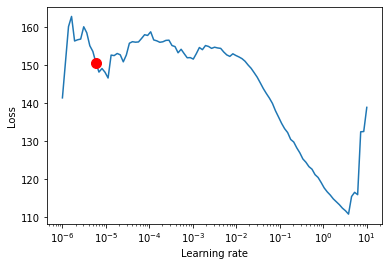

In [50]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

### Train model

In [53]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Number of parameters in network: 29.7k


In [54]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K 
3  | prescalers                         | ModuleDict                      | 256   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.4 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Global seed set to 42


### Hyperparameter tuning
Hyperparamter tuning with [optuna](https://optuna.org/) is directly build into pytorch-forecasting. For example, we can use the optimize_hyperparameters() function to optimize the TFT’s hyperparameters.

In [ ]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

## Evaluate performane
PyTorch Lightning automatically checkpoints training and thus, we can easily retrieve the best model and load it.

In [55]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [56]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(262.2700)

We can now also look at sample predictions directly which we plot with plot_prediction(). As you can see from the figures below, forecasts look rather accurate. If you wonder, the grey lines denote the amount of attention the model pays to different points in time when making the prediction. This is a special feature of the Temporal Fusion Transformer.

In [57]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

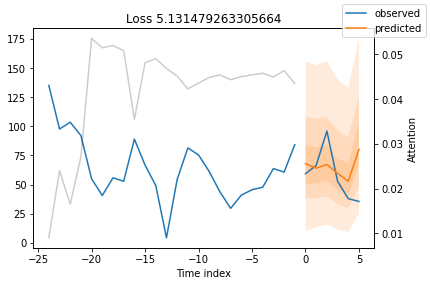

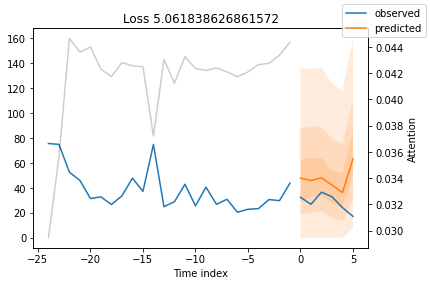

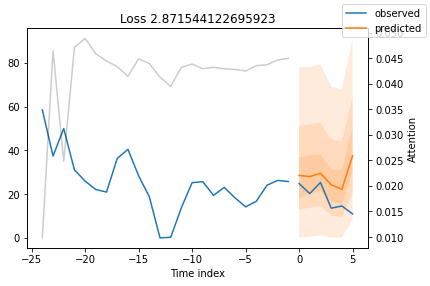

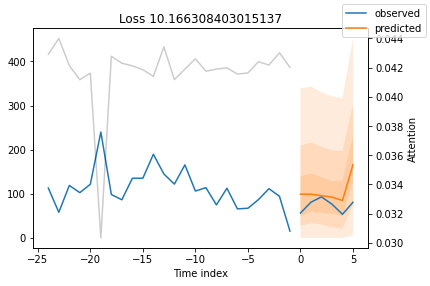

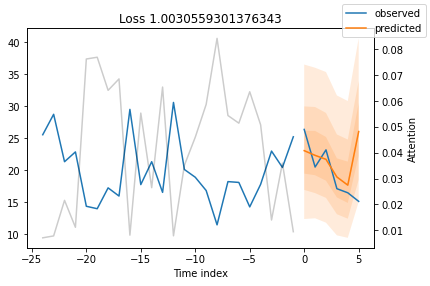

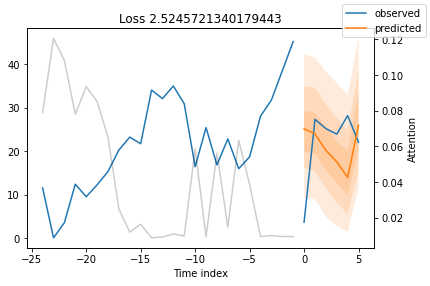

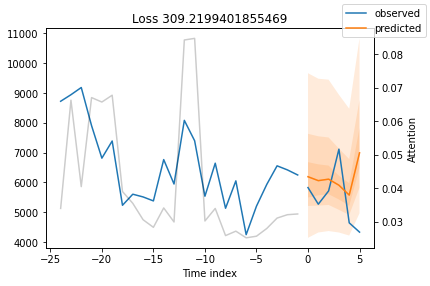

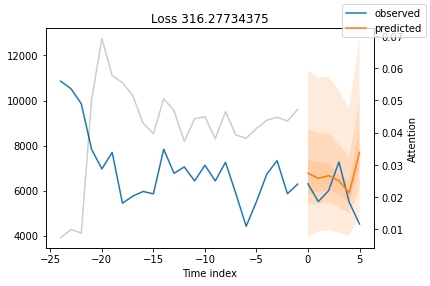

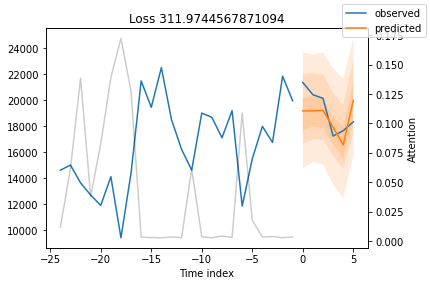

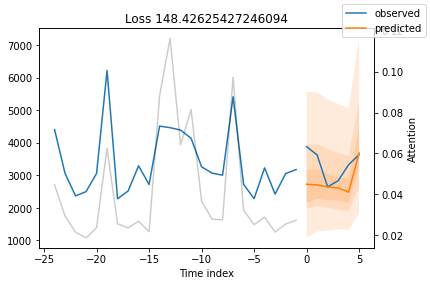

In [58]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

## Worst performers

Looking at the worst performers, for example in terms of SMAPE, gives us an idea where the model has issues with forecasting reliably. These examples can provide important pointers about how to improve the model. This kind of actuals vs predictions plots are available to all models. Of course, it is also sensible to employ additional metrics, such as MASE, defined in the metrics module. However, for the sake of demonstration, we only use SMAPE here.

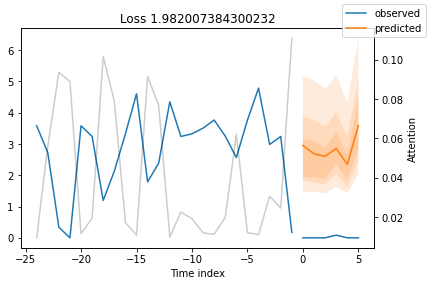

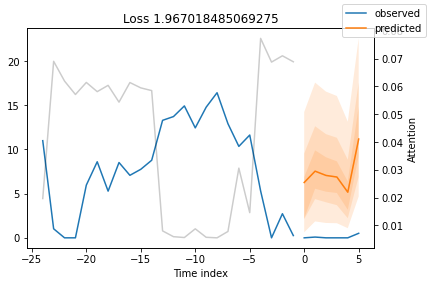

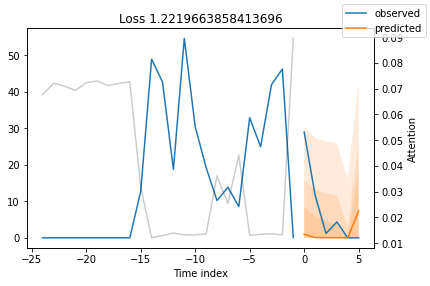

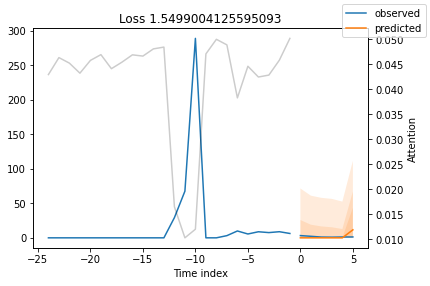

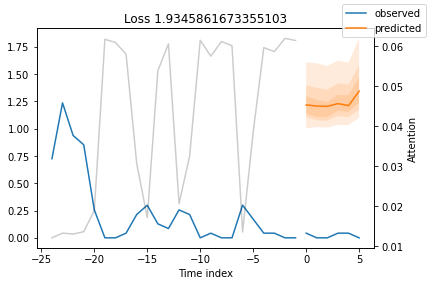

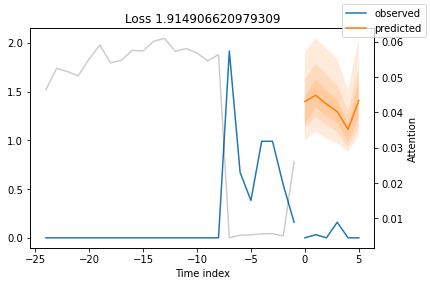

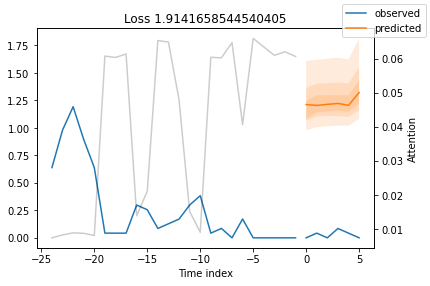

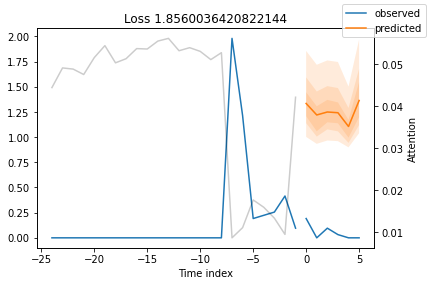

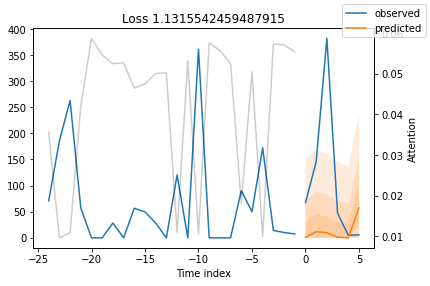

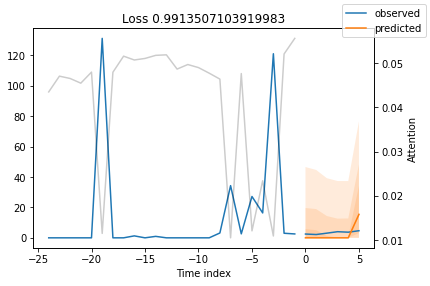

In [59]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
    );

## Predict on new data
Because we have covariates in the dataset, predicting on new data requires us to define the known covariates upfront.

In [66]:
# select last 24 months from data (max_encoder_length is 24)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]


In [67]:
encoder_data.head()

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,easter_day,good_friday,new_year,christmas,labor_day,independence_day,revolution_day_memorial,regional_games,fifa_u_17_world_cup,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
1395,Agency_04,SKU_03,329.9400,2016-01-01,517389425,787479774,20.331481,1555.174877,1364.590954,190.583923,50753,117957,-,-,new_year,-,-,-,-,-,-,-,-,-,12.254823,215,36,1,5.798911,1305.280042,79.21512
1396,Agency_05,SKU_04,2983.4910,2016-01-01,517389425,787479774,24.405797,2135.424114,1801.804597,333.619517,3044268,182944,-,-,new_year,-,-,-,-,-,-,-,-,-,15.623103,20,36,1,8.000849,942.376267,1410.06020
1394,Agency_03,SKU_05,544.0446,2016-01-01,517389425,787479774,20.331481,1627.401548,1347.982304,279.419244,1538040,217280,-,-,new_year,-,-,-,-,-,-,-,-,-,17.169656,202,36,1,6.299031,1091.665142,1580.95485
1397,Agency_42,SKU_05,371.5146,2016-01-01,517389425,787479774,22.841758,1629.296555,1228.912937,400.383618,175794,110057,-,-,new_year,-,-,-,-,-,-,-,-,-,24.574017,348,36,1,5.917588,1091.665142,316.03284
1221,Agency_46,SKU_17,0.0000,2016-01-01,517389425,787479774,23.100990,0.000000,0.000000,0.000000,1709754,212229,-,-,new_year,-,-,-,-,-,-,-,-,-,0.000000,321,36,1,-18.420681,0.000000,2971.67295


In [68]:

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)


In [69]:
last_data.head()

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,easter_day,good_friday,new_year,christmas,labor_day,independence_day,revolution_day_memorial,regional_games,fifa_u_17_world_cup,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
6885,Agency_52,SKU_02,1455.40800,2017-12-01,618073219,919709619,30.759805,1709.140347,1403.137086,306.003261,149811,131764,-,-,-,christmas,-,-,-,-,-,-,-,-,17.903928,47,59,12,7.283042,2267.730115,590.241720
6886,Agency_32,SKU_05,3606.51600,2017-12-01,618073219,919709619,22.717406,1924.429706,1559.952757,364.476949,1199179,126063,-,-,-,christmas,-,-,-,-,-,-,-,-,18.939478,147,59,12,8.190497,1530.930920,1863.056125
6890,Agency_09,SKU_21,0.92655,2017-12-01,618073219,919709619,31.129991,2476.908694,2233.819815,243.088879,1646094,213511,-,-,-,christmas,-,-,-,-,-,-,-,-,9.814204,53,59,12,-0.076287,0.354645,2434.174114
6888,Agency_08,SKU_04,186.77970,2017-12-01,618073219,919709619,25.373665,2486.862499,1934.749052,552.113447,71662,123610,-,-,-,christmas,-,-,-,-,-,-,-,-,22.201205,335,59,12,5.229930,1408.486009,76.037400
6889,Agency_52,SKU_05,963.10050,2017-12-01,618073219,919709619,30.759805,1890.908050,1632.868569,258.039481,149811,131764,-,-,-,christmas,-,-,-,-,-,-,-,-,13.646326,46,59,12,6.870158,1530.930920,590.241720


In [70]:
decoder_data

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,easter_day,good_friday,new_year,christmas,labor_day,independence_day,revolution_day_memorial,regional_games,fifa_u_17_world_cup,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
0,Agency_52,SKU_02,1455.40800,2018-01-01,618073219,919709619,30.759805,1709.140347,1403.137086,306.003261,149811,131764,-,-,-,christmas,-,-,-,-,-,-,-,-,17.903928,47,59,12,7.283042,2267.730115,590.241720
1,Agency_32,SKU_05,3606.51600,2018-01-01,618073219,919709619,22.717406,1924.429706,1559.952757,364.476949,1199179,126063,-,-,-,christmas,-,-,-,-,-,-,-,-,18.939478,147,59,12,8.190497,1530.930920,1863.056125
2,Agency_09,SKU_21,0.92655,2018-01-01,618073219,919709619,31.129991,2476.908694,2233.819815,243.088879,1646094,213511,-,-,-,christmas,-,-,-,-,-,-,-,-,9.814204,53,59,12,-0.076287,0.354645,2434.174114
3,Agency_08,SKU_04,186.77970,2018-01-01,618073219,919709619,25.373665,2486.862499,1934.749052,552.113447,71662,123610,-,-,-,christmas,-,-,-,-,-,-,-,-,22.201205,335,59,12,5.229930,1408.486009,76.037400
4,Agency_52,SKU_05,963.10050,2018-01-01,618073219,919709619,30.759805,1890.908050,1632.868569,258.039481,149811,131764,-,-,-,christmas,-,-,-,-,-,-,-,-,13.646326,46,59,12,6.870158,1530.930920,590.241720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,Agency_08,SKU_03,9.81360,2018-06-01,618073219,919709619,25.373665,1706.410263,1455.262060,251.148203,71662,123610,-,-,-,christmas,-,-,-,-,-,-,-,-,14.717926,336,59,12,2.283769,2304.827516,76.037400
2096,Agency_60,SKU_05,2235.34950,2018-06-01,618073219,919709619,23.081069,1898.981558,1528.616113,370.365445,2180611,211936,-,-,-,christmas,-,-,-,-,-,-,-,-,19.503372,188,59,12,7.712153,1530.930920,3311.367493
2097,Agency_19,SKU_05,87.54300,2018-06-01,618073219,919709619,27.432590,1902.160687,1547.299733,354.860954,48146,122042,-,-,-,christmas,-,-,-,-,-,-,-,-,18.655677,162,59,12,4.472130,1530.930920,56.557950
2098,Agency_60,SKU_03,325.87920,2018-06-01,618073219,919709619,23.081069,1704.503815,1444.443913,260.059902,2180611,211936,-,-,-,christmas,-,-,-,-,-,-,-,-,15.257220,187,59,12,5.786527,2304.827516,3311.367493


In [71]:

# add time index consistent with "data"
decoder_data["time_idx"] = decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

In [74]:
new_prediction_data[(new_prediction_data["agency"]=="Agency_22") & (new_prediction_data["sku"]=="SKU_01")].head()

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,easter_day,good_friday,new_year,christmas,labor_day,independence_day,revolution_day_memorial,regional_games,fifa_u_17_world_cup,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
191,Agency_22,SKU_01,70.308,2016-01-01,517389425,787479774,25.004348,1450.182081,1308.594653,141.587428,48151,132110,-,-,new_year,-,-,-,-,-,-,-,-,-,9.763424,0,36,1,4.252886,2321.331231,113.35536
433,Agency_22,SKU_01,110.592,2016-02-01,532697061,729418593,26.881176,1448.967691,1307.609110,141.358581,48151,132110,-,-,-,-,-,-,-,-,-,-,-,-,9.755813,0,37,2,4.705848,2604.332769,124.57440
774,Agency_22,SKU_01,122.040,2016-03-01,556542731,852685632,30.334118,1450.765625,1316.033854,134.731771,48151,132110,easter_day,good_friday,-,-,-,-,-,-,-,-,-,-,9.286943,0,38,3,4.804349,3160.437173,164.15694
1259,Agency_22,SKU_01,115.884,2016-04-01,589172265,864686985,32.862195,1473.435869,1346.730435,126.705434,48151,132110,-,-,-,-,-,-,-,-,-,-,-,music_fest,8.599318,0,39,4,4.752590,3489.564923,157.21884
1416,Agency_22,SKU_01,152.388,2016-05-01,555318882,953568835,34.031395,1477.796875,1334.620535,143.176340,48151,132110,-,-,-,-,labor_day,-,-,-,-,-,-,-,9.688499,0,40,5,5.026430,3412.103192,188.17812


In [73]:
new_prediction_data[(new_prediction_data["agency"]=="Agency_22") & (new_prediction_data["sku"]=="SKU_01")].tail()

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,easter_day,good_friday,new_year,christmas,labor_day,independence_day,revolution_day_memorial,regional_games,fifa_u_17_world_cup,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
9059,Agency_22,SKU_01,120.204,2018-02-01,618073219,919709619,26.91561,1712.552954,1389.759996,322.792958,48151,132110,-,-,-,christmas,-,-,-,-,-,-,-,-,18.848641,0,61,2,4.78919,2716.823019,161.39034
9409,Agency_22,SKU_01,120.204,2018-03-01,618073219,919709619,26.91561,1712.552954,1389.759996,322.792958,48151,132110,-,-,-,christmas,-,-,-,-,-,-,-,-,18.848641,0,62,3,4.78919,2716.823019,161.39034
9759,Agency_22,SKU_01,120.204,2018-04-01,618073219,919709619,26.91561,1712.552954,1389.759996,322.792958,48151,132110,-,-,-,christmas,-,-,-,-,-,-,-,-,18.848641,0,63,4,4.78919,2716.823019,161.39034
10109,Agency_22,SKU_01,120.204,2018-05-01,618073219,919709619,26.91561,1712.552954,1389.759996,322.792958,48151,132110,-,-,-,christmas,-,-,-,-,-,-,-,-,18.848641,0,64,5,4.78919,2716.823019,161.39034
10459,Agency_22,SKU_01,120.204,2018-06-01,618073219,919709619,26.91561,1712.552954,1389.759996,322.792958,48151,132110,-,-,-,christmas,-,-,-,-,-,-,-,-,18.848641,0,65,6,4.78919,2716.823019,161.39034


In [75]:
new_prediction_data.shape

(10500, 31)

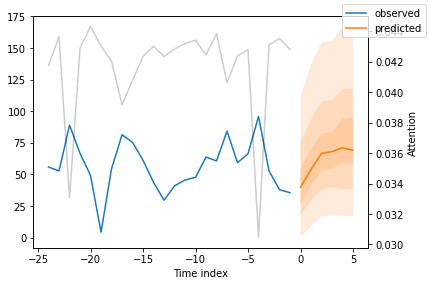

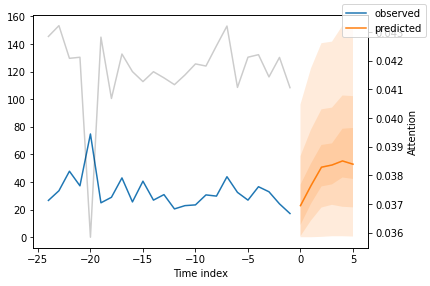

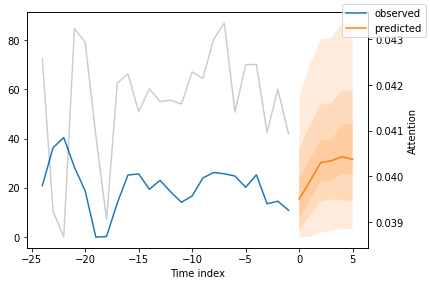

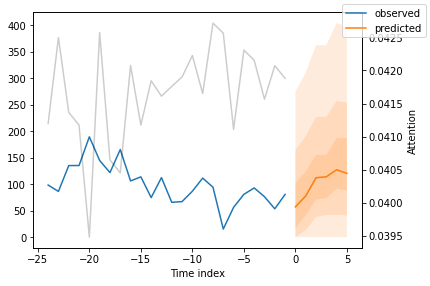

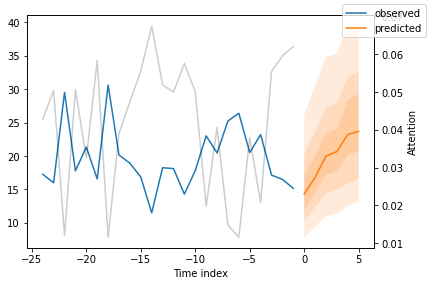

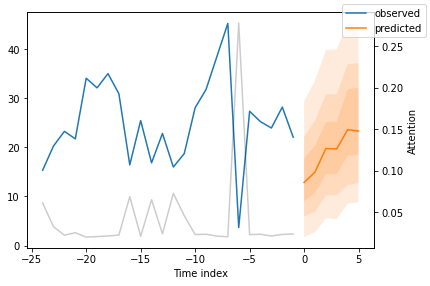

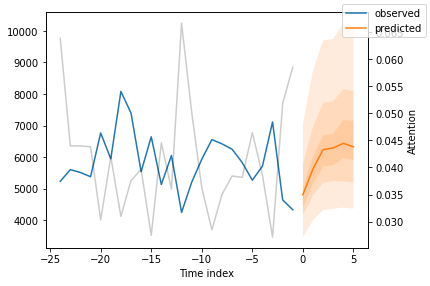

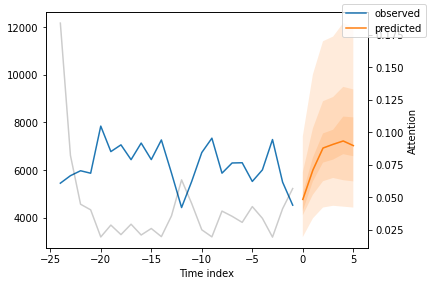

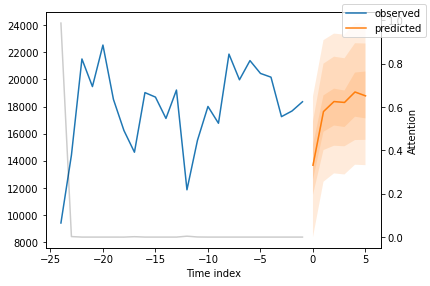

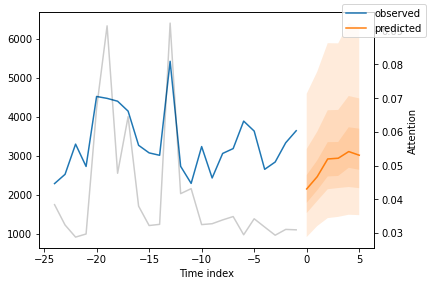

In [76]:
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False);

### Variable importances

{'attention': <Figure size 432x288 with 1 Axes>,
 'decoder_variables': <Figure size 504x252 with 1 Axes>,
 'encoder_variables': <Figure size 504x378 with 1 Axes>,
 'static_variables': <Figure size 504x270 with 1 Axes>}

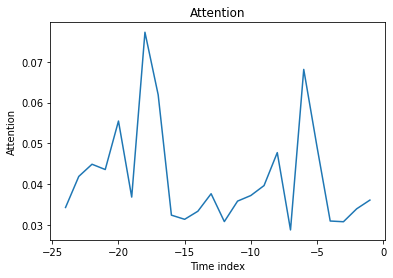

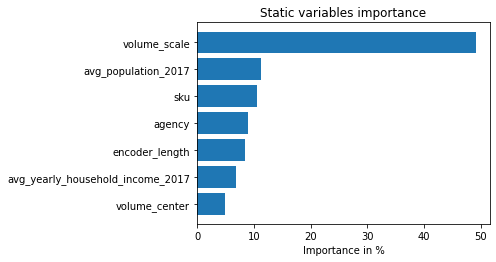

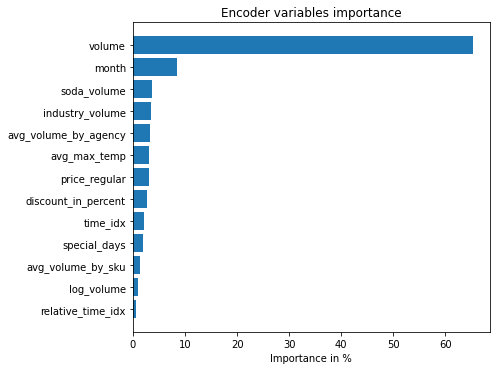

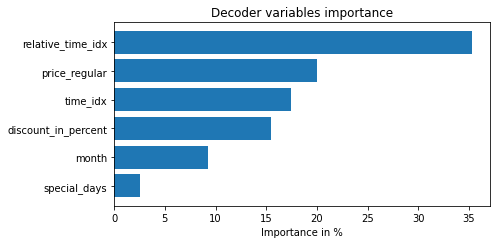

In [77]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

Unsurprisingly, the past observed volume features as the top variable in the encoder and price related variables are among the top predictors in the decoder.

The general attention patterns seems to be that more recent observations are more important and older ones. This confirms intuition. The average attention is often not very useful - looking at the attention by example is more insightful because patterns are not averaged out.